# Full Artificial Neural Network Code Along
The goal is to estimate the cost of a New York City cab ride from several inputs. The inspiration behind this code along is a recent <a href='https://www.kaggle.com/c/new-york-city-taxi-fare-prediction'>Kaggle competition</a>.

<div class="alert alert-success"><strong>NOTE:</strong> In this notebook we'll perform a regression with one output value. In the next one we'll perform a binary classification with two output values.</div>

## Working with tabular data
Deep learning with neural networks is often associated with sophisticated image recognition, and in upcoming sections we'll train models based on properties like pixels patterns and colors.

Here we're working with tabular data (spreadsheets, SQL tables, etc.) with columns of values that may or may not be relevant. As it happens, neural networks can learn to make connections we probably wouldn't have developed on our own. However, to do this we have to handle categorical values separately from continuous ones.
* continuous vs. categorical values
* embeddings
* batch normalization
* dropout layers

## Perform standard imports

In [1]:
import torch
import torch.nn as nn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

## Load the NYC Taxi Fares dataset
The <a href='https://www.kaggle.com/c/new-york-city-taxi-fare-prediction'>Kaggle competition</a> provides a dataset with about 55 million records. The data contains only the pickup date & time, the latitude & longitude (GPS coordinates) of the pickup and dropoff locations, and the number of passengers.

> For instance, does the time of day matter? The day of the week? How do we determine the distance traveled from pairs of GPS coordinates?


> an artificial neural network can really only take in straight numerical data and it's not going to be able to understand direct complex data such as a full date timestamp.
So a full date timestamp contains as a string code, or at least it looks kind of like a string code. Things like the year, the month, the date, the hour, the minute, the second. A network just can't take in that data raw.
What you need to do is you need to use feature engineering to separate it out into useful components, things like Am versus PM or the hour of the day on a 24 hour clock. So then it's a value between 0 and 24.

> we need to do the same thing for things like longitude and latitude measurements. You could try to just pass those in in their raw format, longitude and latitude, but then you'll have to have a really large network because the network would have to try to learn the relationship between longitude and latitude.

> And then there's the added complexity of latitude and longitude. Since it's determined on the equator, there may be issues with things being positive and negative.

> And also then you have issues of things like the actual resolution of that latitude and longitude. If you're doing all your pick up and drop offs within the same city, essentially the significant digits beyond that decimal point are going to be really substantial because latitude and longitude doesn't change much within the distance of a city. You're looking at changes of maybe 0.001 scale.

Lets calculate distance from GPS coordinates, and how to create a pandas datatime object from a text column. This will let us quickly get information like day of the week, am vs. pm, etc.




1.   pickup_datetime - timestamp value indicating when the taxi ride started.
2. pickup_longitude - float for longitude coordinate of where the taxi ride started.
3. pickup_latitude - float for latitude coordinate of where the taxi ride started.
4. dropoff_longitude - float for longitude coordinate of where the taxi ride ended.
5. dropoff_latitude - float for latitude coordinate of where the taxi ride ended.
6. passenger_count - integer indicating the number of passengers in the taxi ride.

7. Target
fare_amount - float dollar amount of the cost of the taxi ride. This value is only in the training set; this is what you are predicting in the test set and it is required in your submission CSV.



In [2]:
#df = pd.read_csv('../Data/NYCTaxiFares.csv')

df = pd.read_csv('NYCTaxiFares.csv')
df.head()

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2010-04-19 08:17:56 UTC,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1
1,2010-04-17 15:43:53 UTC,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1
2,2010-04-17 11:23:26 UTC,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2
3,2010-04-11 21:25:03 UTC,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1
4,2010-04-17 02:19:01 UTC,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1


In [3]:
df['fare_amount'].describe()

count    120000.000000
mean         10.040326
std           7.500134
min           2.500000
25%           5.700000
50%           7.700000
75%          11.300000
max          49.900000
Name: fare_amount, dtype: float64

From this we see that fares range from \\$2.50 to \\$49.90, with a mean of \\$10.04 and a median of \\$7.70

## Calculate the distance traveled
The <a href='https://en.wikipedia.org/wiki/Haversine_formula'>haversine formula</a> calculates the distance on a sphere between two sets of GPS coordinates.<br>

Right now we only have direct longitudes and latitudes.
And if you were to train the network on the direct longitudes and latitudes, you would notice that
it doesn't actually perform that well.
There's a couple of reasons for that.

One is because it's kind of difficult to interpret a direct longitude and latitude.

Another reason for that is because within just New York City, there's not going to be extreme changes
in longitude and latitude, especially for shorter trips.

And we can see here we're dealing with our particular data set just around a $10 trip, which isn't
a trip that's very long, which means if you take a look at these longitude changes, the longitude,
the actual significant digits, where you'd have to actually start seeing changes is pretty extreme.
It's beyond just these two decimal places.
So some of these if you're only to look at these first four digits, they would look exactly the same
between the pickup locations and the drop off locations.
So if we look at the drop off locations, you can see these are still at 73.9 something.
So that difference is an issue for us.
And what would probably be a better feature to actually take into account is the distance between the
pickup points and the drop off points.
And for that, we'll need to actually figure out how we calculate the distance traveled from two setsof GPS coordinates.


Here we assign latitude values with $\varphi$ (phi) and longitude with $\lambda$ (lambda).

The distance formula works out to

${\displaystyle d=2r\arcsin \left({\sqrt {\sin ^{2}\left({\frac {\varphi _{2}-\varphi _{1}}{2}}\right)+\cos(\varphi _{1})\:\cos(\varphi _{2    r = 6371 })\:\sin ^{2}\left({\frac {\lambda _{2}-\lambda _{1}}{2}}\right)}}\right)}$

where

$\begin{split} r&: \textrm {radius of the sphere (Earth's radius averages 6371 km)}\\
\varphi_1, \varphi_2&: \textrm {latitudes of point 1 and point 2}\\
\lambda_1, \lambda_2&: \textrm {longitudes of point 1 and point 2}\end{split}$

In [4]:
r = 6371
long1 = -73.992365
lat1 = 40.730521
long2 = -73.975499
lat2 = 40.744746

phi1 = np.radians(lat1)
phi2 = np.radians(lat2)

delta_phi = np.radians(lat2-lat1)
delta_lambda = np.radians(long2-long1)

a = np.sin(delta_phi/2)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda/2)**2
d = 2 * r* np.arcsin(np.sqrt(a))
d

2.126311585679373

In [5]:
r = 6371
long1 = -73.992365
lat1 = 40.730521
long2 = -73.975499
lat2 = 40.744746

phi1 = np.radians(lat1)
phi2 = np.radians(lat2)

delta_phi = np.radians(lat2-lat1)
delta_lambda = np.radians(long2-long1)

a = np.sin(delta_phi/2)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda/2)**2
c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
d = (r * c) # in kilometers
d

2.126311585679373

In [6]:

np.arccos(np.sin(lat1)*np.sin(lat2)+np.cos(lat1)*np.cos(lat2)*np.cos(long2-long1))*6371

140.13249913646146

In [7]:
def haversine_distance(df, lat1, long1, lat2, long2):
    """
    Calculates the haversine distance between 2 sets of GPS coordinates in df
    """
    r = 6371  # average radius of Earth in kilometers

    phi1 = np.radians(df[lat1])
    phi2 = np.radians(df[lat2])

    delta_phi = np.radians(df[lat2]-df[lat1])
    delta_lambda = np.radians(df[long2]-df[long1])

    a = np.sin(delta_phi/2)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    d = (r * c) # in kilometers

    return d

In [8]:
df['dist_km'] = haversine_distance(df,'pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude')
df.head()

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,dist_km
0,2010-04-19 08:17:56 UTC,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1,2.126312
1,2010-04-17 15:43:53 UTC,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1,1.392307
2,2010-04-17 11:23:26 UTC,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2,3.326763
3,2010-04-11 21:25:03 UTC,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1,1.864129
4,2010-04-17 02:19:01 UTC,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1,7.231321


## Add a datetime column and derive useful statistics
By creating a datetime object, we can extract information like "day of the week", "am vs. pm" etc.
Note that the data was saved in UTC time. Our data falls in April of 2010 which occurred during Daylight Savings Time in New York. For that reason, we'll make an adjustment to EDT using UTC-4 (subtracting four hours).

In [9]:
x = pd.to_datetime(df['pickup_datetime'])

In [10]:
my_time  = x[0]

In [11]:
my_time

Timestamp('2010-04-19 08:17:56+0000', tz='UTC')

In [12]:
#just type my_time. and wait and u will see lot of methods available
my_time.dayofyear

109

But what things do you think are important due to the date time stamp of the pickup and try to actually extract those features because a neural network is not going to be able to understand this date time object, just put in straight.
Instead, what we need to do is do some feature engineering to actually extract those.
Recall that all of these taxi rides are occurring within New York City, which is on Eastern Standard Time.
But if we take a look back at this pickup date time stamp, right now, it's under UTC, which actually
means there's a four hour difference because due to our data, it's also falling in April.
And so if you take a look at some of these timestamps, actually, let's just call. Df.head.
These time stamps are occurring in April of 2010, and that actually occurred during daylight savings time.

So there's a time delta or difference in time of four hours between this timestamp and the actual time it was in New York City when this pickup actually happened.

So while this time is technically true, the there's a four hour difference for the actual passenger riding on the car.

That's important because it lets us know things like if it was Am or PM. So we're going to have to take that into account.

So let's go ahead and make sure that when we're calculating these things, we'll have an adjusted date by four hours.
And one way we can easily do that is by simply creating a new column, we'll say DF EDT date so that Eastern time will be equal to.


In [13]:
df['pickup_datetime'][0]

'2010-04-19 08:17:56 UTC'

In [14]:
df['pickup_datetime'][0][:19]

'2010-04-19 08:17:56'

In [15]:
df['EDTdate'] = pd.to_datetime(df['pickup_datetime'].str[:19]) - pd.Timedelta(hours=4)
df['Hour'] = df['EDTdate'].dt.hour
df['AMorPM'] = np.where(df['Hour']<12,'am','pm')
df['Weekday'] = df['EDTdate'].dt.strftime("%a")
df.head()

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,dist_km,EDTdate,Hour,AMorPM,Weekday
0,2010-04-19 08:17:56 UTC,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1,2.126312,2010-04-19 04:17:56,4,am,Mon
1,2010-04-17 15:43:53 UTC,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1,1.392307,2010-04-17 11:43:53,11,am,Sat
2,2010-04-17 11:23:26 UTC,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2,3.326763,2010-04-17 07:23:26,7,am,Sat
3,2010-04-11 21:25:03 UTC,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1,1.864129,2010-04-11 17:25:03,17,pm,Sun
4,2010-04-17 02:19:01 UTC,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1,7.231321,2010-04-16 22:19:01,22,pm,Fri


In [16]:
df['EDTdate'].min()

Timestamp('2010-04-11 00:00:10')

In [17]:
df['EDTdate'].max()

Timestamp('2010-04-24 23:59:42')

## Separate categorical from continuous columns

In [18]:
df.columns

Index(['pickup_datetime', 'fare_amount', 'fare_class', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'passenger_count', 'dist_km', 'EDTdate', 'Hour', 'AMorPM', 'Weekday'],
      dtype='object')

In [19]:
df.dtypes

pickup_datetime              object
fare_amount                 float64
fare_class                    int64
pickup_longitude            float64
pickup_latitude             float64
dropoff_longitude           float64
dropoff_latitude            float64
passenger_count               int64
dist_km                     float64
EDTdate              datetime64[ns]
Hour                          int64
AMorPM                       object
Weekday                      object
dtype: object

In [20]:
cat_cols = ['Hour', 'AMorPM', 'Weekday']
cont_cols = ['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude', 'passenger_count', 'dist_km']
y_col = ['fare_amount']  # this column contains the labels
# we will use the fare_class as y_col for classification problem

<div class="alert alert-info"><strong>NOTE:</strong> If you plan to use all of the columns in the data table, there's a shortcut to grab the remaining continuous columns:<br>
<pre style='background-color:rgb(217,237,247)'>cont_cols = [col for col in df.columns if col not in cat_cols + y_col]</pre>

Here we entered the continuous columns explicitly because there are columns we're not running through the model (pickup_datetime and EDTdate)</div>


## Categorify
Pandas offers a <a href='https://pandas.pydata.org/pandas-docs/stable/user_guide/categorical.html'><strong>category dtype</strong></a> for converting categorical values to numerical codes. A dataset containing months of the year will be assigned 12 codes, one for each month. These will usually be the integers 0 to 11. Pandas replaces the column values with codes, and retains an index list of category values. In the steps ahead we'll call the categorical values "names" and the encodings "codes".

In [21]:
# Convert our three categorical columns to category dtypes.
for cat in cat_cols:
    df[cat] = df[cat].astype('category')

In [22]:
df.dtypes

pickup_datetime              object
fare_amount                 float64
fare_class                    int64
pickup_longitude            float64
pickup_latitude             float64
dropoff_longitude           float64
dropoff_latitude            float64
passenger_count               int64
dist_km                     float64
EDTdate              datetime64[ns]
Hour                       category
AMorPM                     category
Weekday                    category
dtype: object

We can see that <tt>df['Hour']</tt> is a categorical feature by displaying some of the rows:

In [23]:
df['Hour'].head()

0     4
1    11
2     7
3    17
4    22
Name: Hour, dtype: category
Categories (24, int64): [0, 1, 2, 3, ..., 20, 21, 22, 23]

Here our categorical names are the integers 0 through 23, for a total of 24 unique categories. These values <em>also</em> correspond to the codes assigned to each name.

We can access the category names with <tt>Series.cat.categories</tt> or just the codes with <tt>Series.cat.codes</tt>. This will make more sense if we look at <tt>df['AMorPM']</tt>:

In [24]:
df['AMorPM'].head()

0    am
1    am
2    am
3    pm
4    pm
Name: AMorPM, dtype: category
Categories (2, object): ['am', 'pm']

In [25]:
df['AMorPM'].cat.categories

Index(['am', 'pm'], dtype='object')

In [26]:
df['AMorPM'].head().cat.codes

0    0
1    0
2    0
3    1
4    1
dtype: int8

In [27]:
df['Weekday'].cat.categories

Index(['Fri', 'Mon', 'Sat', 'Sun', 'Thu', 'Tue', 'Wed'], dtype='object')

In [28]:
df['Weekday'].head()

0    Mon
1    Sat
2    Sat
3    Sun
4    Fri
Name: Weekday, dtype: category
Categories (7, object): ['Fri', 'Mon', 'Sat', 'Sun', 'Thu', 'Tue', 'Wed']

In [29]:
df['Weekday'].head().cat.codes

0    1
1    2
2    2
3    3
4    0
dtype: int8

<div class="alert alert-info"><strong>NOTE: </strong>NaN values in categorical data are assigned a code of -1. We don't have any in this particular dataset.</div>

Now we want to combine the three categorical columns into one input array using <a href='https://docs.scipy.org/doc/numpy/reference/generated/numpy.stack.html'><tt>numpy.stack</tt></a> We don't want the Series index, just the values.


And recall that when we're turning things into tensors, we first need them in a numpy array format and then we can cast them into a pytorch tensor.

In [30]:
df['Hour'].cat.codes.values # to get numpy array

array([ 4, 11,  7, ..., 14,  4, 12], dtype=int8)

In [31]:
hr = df['Hour'].cat.codes.values
ampm = df['AMorPM'].cat.codes.values
wkdy = df['Weekday'].cat.codes.values

cats = np.stack([hr, ampm, wkdy],axis=1)

cats[:5]

array([[ 4,  0,  1],
       [11,  0,  2],
       [ 7,  0,  2],
       [17,  1,  3],
       [22,  1,  0]], dtype=int8)

<div class="alert alert-info"><strong>NOTE:</strong> This can be done in one line of code using a list comprehension:
<pre style='background-color:rgb(217,237,247)'>cats = np.stack([df[col].cat.codes.values for col in cat_cols], axis = 1)</pre>

Don't worry about the dtype for now, we can make it int64 when we convert it to a tensor.</div>


## Convert numpy arrays to tensors

In [32]:
# Convert categorical variables to a tensor
cats = torch.tensor(cats, dtype=torch.int64)
# this syntax is ok, since the source data is an array, not an existing tensor

cats[:5]

tensor([[ 4,  0,  1],
        [11,  0,  2],
        [ 7,  0,  2],
        [17,  1,  3],
        [22,  1,  0]])

We can feed all of our continuous variables into the model as a tensor. Note that we're not normalizing the values here; we'll let the model perform this step.
<div class="alert alert-info"><strong>NOTE:</strong> We have to store <tt>conts</tt> and <tt>y</tt> as Float (float32) tensors, not Double (float64) in order for batch normalization to work properly.</div>

In [33]:
# Convert continuous variables to a tensor
conts = np.stack([df[col].values for col in cont_cols], axis = 1)
conts = torch.tensor(conts, dtype=torch.float)
conts[:5]

tensor([[ 40.7305, -73.9924,  40.7447, -73.9755,   1.0000,   2.1263],
        [ 40.7406, -73.9901,  40.7441, -73.9742,   1.0000,   1.3923],
        [ 40.7511, -73.9941,  40.7662, -73.9601,   2.0000,   3.3268],
        [ 40.7564, -73.9905,  40.7482, -73.9712,   1.0000,   1.8641],
        [ 40.7342, -73.9910,  40.7431, -73.9060,   1.0000,   7.2313]])

In [34]:
conts.type()

'torch.FloatTensor'

In [35]:
# Convert labels to a tensor
y = torch.tensor(df[y_col].values, dtype=torch.float).reshape(-1,1)
# for categorical output we are not reshaping and also we r not one hot encoding as we are using categorical cross entropy as loss
# for continuous  output we are reshaping to get [[op1],[op2],.....[opn]]

y[:5]

tensor([[ 6.5000],
        [ 6.9000],
        [10.1000],
        [ 8.9000],
        [19.7000]])

In [36]:
cats.shape

torch.Size([120000, 3])

In [37]:
conts.shape

torch.Size([120000, 6])

In [38]:
y.shape

torch.Size([120000, 1])

https://www.quora.com/What-does-PyTorch-Embedding-do     --Prasoon Goyal

## Set an embedding size
The rule of thumb for determining the embedding size is to divide the number of unique entries in each column by 2, but not to exceed 50.
Every deep learning framework has such an embedding layer. Let’s see why it is useful.

Suppose you are working with images. An image is represented as a matrix of RGB values. Each RGB value is a feature that is numerical, that is, values 5 and 10 are closer than values 5 and 100. This information is implicitly used by the network to identify which images are close to each other, by comparing their individual pixel values.

Now, let’s say you are working with text, in particular, sentences. Each sentence is composed of words, which are categorical variables, not numerical. How would you feed a word to a NN? One way to do this is to use one-hot vectors, wherein, you decide on the set of all words you will use [the “vocabulary”]. Let’s say your vocabulary has 10000 words, and you have defined an ordering over these words — “a”, “the”, “they”, “are”, “have”, etc. Now, you can represent the first word in the ordering [“a”] as [1, 0, 0, 0, ….], which is a vector of size 10000 with all zeros except a 1 at position 1. Similarly, the second, third, …, words can be defined as [0, 1, 0, 0, ….], [0, 0, 1, 0, ….], … So, the  ith
  word will be a vector of size 10,000 with all zeros, except a 1 at the  ith
  position. Now, we have a way to feed the words into the NN. But the notion of distance that we had in case of images is not present. All words are equidistant from all other words. Secondly, the dimension of the input is huge. Your vocabulary size could easily go to 100,000 or more.

Therefore, instead of having a sparse vector for each word, you can have a dense vector for each word, that is, multiple elements of the vector are nonzero and each element of the vector can take continuous values. This immediately reduces the size of the vector. You can have infinite number of unique vectors of size, say 10, where each element can take any arbitrary value [as opposed to one-hot vectors where each element could take only values 0 or 1]. So, for instance, “a” could be represented as [0.13, 0.46, 0.85, 0.96, 0.66, 0.12, 0.01, 0.38, 0.76, 0.95], “the” could be represented as [0.73, 0.45, 0.25, 0.91, 0.06, 0.16, 0.11, 0.36, 0.76, 0.98], and so on. The size of the vectors is a hyperparameter, set using cross-validation. So, how do you feed these dense vector representations of words into the network? The answer is an embedding layer — you will have an embedding layer that is essentially a matrix of size 10,000 x 10 [or more generally,  vocab_size×dense_vector_size
 ].



 For every word, you have an index in the vocabulary, like “a” -> 0, “the” -> 1, etc., and you simply look up the corresponding row in the embedding matrix to get its 10-dimensional representation as the output.



Now, the embedding layer could be fixed, so that you don’t train it when you train the NN. This could be done, for instance, when you initialize your embedding layer using pretrained word vectors for the words.



Alternately, you can initialize the embedding layer randomly, and train it with the other layers. Finally, you could do both — initialize with the word vectors and finetune on the task. In any case, the embeddings of similar words are similar, solving the issue we had with one-hot vectors.

In [39]:
cat_cols

['Hour', 'AMorPM', 'Weekday']

In [40]:
# This will set embedding sizes for Hours, AMvsPM and Weekdays
cat_szs = [len(df[col].cat.categories) for col in cat_cols]
emb_szs = [(size, min(50, (size+1)//2)) for size in cat_szs]

emb_szs

[(24, 12), (2, 1), (7, 4)]

In [41]:
cat_szs

[24, 2, 7]

## Define a TabularModel
This somewhat follows the <a href='https://docs.fast.ai/tabular.models.html'>fast.ai library</a> The goal is to define a model based on the number of continuous columns (given by <tt>conts.shape[1]</tt>) plus the number of categorical columns and their embeddings (given by <tt>len(emb_szs)</tt> and <tt>emb_szs</tt> respectively). The output would either be a regression (a single float value), or a classification (a group of bins and their softmax values). For this exercise our output will be a single regression value. Note that we'll assume our data contains both categorical and continuous data. You can add boolean parameters to your own model class to handle a variety of datasets.

<div class="alert alert-info"><strong>Let's walk through the steps we're about to take. See below for more detailed illustrations of the steps.</strong><br>

1. Extend the base Module class, set up the following parameters:
   * <tt>emb_szs: </tt>list of tuples: each categorical variable size is paired with an embedding size
   * <tt>n_cont:  </tt>int: number of continuous variables
   * <tt>out_sz:  </tt>int: output size
   * <tt>layers:  </tt>list of ints: layer sizes
   * <tt>p:       </tt>float: dropout probability for each layer (for simplicity we'll use the same value throughout)
   
<tt><font color=black>class TabularModel(nn.Module):<br>
&nbsp;&nbsp;&nbsp;&nbsp;def \_\_init\_\_(self, emb_szs, n_cont, out_sz, layers, p=0.5):<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;super().\_\_init\_\_()</font></tt><br>

2. Set up the embedded layers with <a href='https://pytorch.org/docs/stable/nn.html#modulelist'><tt><strong>torch.nn.ModuleList()</strong></tt></a> and <a href='https://pytorch.org/docs/stable/nn.html#embedding'><tt><strong>torch.nn.Embedding()</strong></tt></a><br>Categorical data will be filtered through these Embeddings in the forward section.<br>
<tt><font color=black>&nbsp;&nbsp;&nbsp;&nbsp;self.embeds = nn.ModuleList([nn.Embedding(ni, nf) for ni,nf in emb_szs])</font></tt><br><br>
3. Set up a dropout function for the embeddings with <a href='https://pytorch.org/docs/stable/nn.html#dropout'><tt><strong>torch.nn.Dropout()</strong></tt></a> The default p-value=0.5<br>
<tt><font color=black>&nbsp;&nbsp;&nbsp;&nbsp;self.emb_drop = nn.Dropout(emb_drop)</font></tt><br><br>

what a dropout layer does is during training, it's going to randomly zero some of the elements of the input tensor with some sort of probability that you provide.
So you by default, it's 50% probability.
But what this does is essentially randomly turns off 50% of the neurons, and that way you don't overfit.
It's a really common strategy.

4. Set up a normalization function for the continuous variables with <a href='https://pytorch.org/docs/stable/nn.html#batchnorm1d'><tt><strong>torch.nn.BatchNorm1d()</strong></tt></a><br>
<tt><font color=black>&nbsp;&nbsp;&nbsp;&nbsp;self.bn_cont = nn.BatchNorm1d(n_cont)</font></tt><br><br>

 we're also going to do is we want to normalize that continuous data to make sure it all falls within the same magnitude.
The order of magnitude range.

5. Set up a sequence of neural network layers where each level includes a Linear function, an activation function (we'll use <a href='https://pytorch.org/docs/stable/nn.html#relu'><strong>ReLU</strong></a>), a normalization step, and a dropout layer. We'll combine the list of layers with <a href='https://pytorch.org/docs/stable/nn.html#sequential'><tt><strong>torch.nn.Sequential()</strong></tt></a><br>
<tt><font color=black>&nbsp;&nbsp;&nbsp;&nbsp;self.bn_cont = nn.BatchNorm1d(n_cont)<br>
&nbsp;&nbsp;&nbsp;&nbsp;layerlist = []<br>
&nbsp;&nbsp;&nbsp;&nbsp;n_emb = sum((nf for ni,nf in emb_szs))<br>
&nbsp;&nbsp;&nbsp;&nbsp;n_in = n_emb + n_cont<br>
<br>
&nbsp;&nbsp;&nbsp;&nbsp;for i in layers:<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;layerlist.append(nn.Linear(n_in,i)) <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;layerlist.append(nn.ReLU(inplace=True))<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;layerlist.append(nn.BatchNorm1d(i))<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;layerlist.append(nn.Dropout(p))<br>

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;n_in = i<br>
&nbsp;&nbsp;&nbsp;&nbsp;layerlist.append(nn.Linear(layers[-1],out_sz))<br>
<br>
&nbsp;&nbsp;&nbsp;&nbsp;self.layers = nn.Sequential(*layerlist)</font></tt><br><br>
6. Define the forward method. Preprocess the embeddings and normalize the continuous variables before passing them through the layers.<br>Use <a href='https://pytorch.org/docs/stable/torch.html#torch.cat'><tt><strong>torch.cat()</strong></tt></a> to combine multiple tensors into one.<br>
<tt><font color=black>&nbsp;&nbsp;&nbsp;&nbsp;def forward(self, x_cat, x_cont):<br>
&nbsp;&nbsp;&nbsp;&nbsp;embeddings = []<br>
&nbsp;&nbsp;&nbsp;&nbsp;for i,e in enumerate(self.embeds):<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;embeddings.append(e(x_cat[:,i]))<br>
&nbsp;&nbsp;&nbsp;&nbsp;x = torch.cat(embeddings, 1)<br>
&nbsp;&nbsp;&nbsp;&nbsp;x = self.emb_drop(x)<br>
<br>
&nbsp;&nbsp;&nbsp;&nbsp;x_cont = self.bn_cont(x_cont)<br>
&nbsp;&nbsp;&nbsp;&nbsp;x = torch.cat([x, x_cont], 1)<br>
&nbsp;&nbsp;&nbsp;&nbsp;x = self.layers(x)<br>
&nbsp;&nbsp;&nbsp;&nbsp;return x</font></tt>
</div>

<div class="alert alert-danger"><strong>Breaking down the embeddings steps</strong> (this code is for illustration purposes only.)</div>

In [42]:
# help(nn.Embedding)

In [43]:
# This is our source data
catz = cats[:4]
catz

tensor([[ 4,  0,  1],
        [11,  0,  2],
        [ 7,  0,  2],
        [17,  1,  3]])

In [44]:
# This is passed in when the model is instantiated
emb_szs

[(24, 12), (2, 1), (7, 4)]

In [45]:
[nn.Embedding(ni, nf) for ni,nf in emb_szs] # Creating a embedding layer

[Embedding(24, 12), Embedding(2, 1), Embedding(7, 4)]

In [46]:
# This is assigned inside the __init__() method
selfembeds = nn.ModuleList([nn.Embedding(ni, nf) for ni,nf in emb_szs])
selfembeds

ModuleList(
  (0): Embedding(24, 12)
  (1): Embedding(2, 1)
  (2): Embedding(7, 4)
)

In [47]:
list(enumerate(selfembeds))

[(0, Embedding(24, 12)), (1, Embedding(2, 1)), (2, Embedding(7, 4))]

In [48]:
# This happens inside the forward() method
embeddingz = []
for i,e in enumerate(selfembeds):
    embeddingz.append(e(catz[:,i])) # by taking each column from all rows and getting a embedding tensor
embeddingz

[tensor([[ 0.1677, -1.6355, -0.9113,  0.8843,  1.5710,  0.8027,  1.0104,  2.5019,
           1.2791,  0.6054,  1.3902, -0.4989],
         [-0.1508, -0.1471,  1.3686, -0.3555, -0.2774,  0.1099, -0.5506,  1.0596,
           0.3595,  0.4859, -1.6289, -0.6530],
         [-0.6778, -0.1558, -3.2439, -1.9364, -0.5427, -0.5546, -2.1623, -0.7389,
           0.9051,  0.0613, -0.6952, -2.4025],
         [ 0.7398, -0.7913, -0.9718,  1.3142, -0.6902,  0.5929, -2.2412, -0.3437,
           0.4038,  0.3001, -0.0516,  0.9254]], grad_fn=<EmbeddingBackward0>),
 tensor([[0.6718],
         [0.6718],
         [0.6718],
         [0.6541]], grad_fn=<EmbeddingBackward0>),
 tensor([[-0.6247, -1.5155,  0.3390, -1.1460],
         [-0.1082,  0.0500,  0.0956, -0.7517],
         [-0.1082,  0.0500,  0.0956, -0.7517],
         [ 1.1388,  0.3222,  1.2124,  0.4271]], grad_fn=<EmbeddingBackward0>)]

And then during the forward method, what actually happens is we end up applying values to each of those one hot encodings until eventually we start putting a lot of strength to maybe our number 12 in a day because that's lunchtime or PM because it's night and rides are going to be more expensive during night or maybe the last two of the weekdays, like Saturday and Sunday or the weekends, etcetera.
So we're actually then assigning numerical values to those one hot encodings that we created through
the embeddings.


In [49]:
# We concatenate the embedding sections (12,1,4) into one (17)
z = torch.cat(embeddingz, axis = 1)
z

tensor([[ 0.1677, -1.6355, -0.9113,  0.8843,  1.5710,  0.8027,  1.0104,  2.5019,
          1.2791,  0.6054,  1.3902, -0.4989,  0.6718, -0.6247, -1.5155,  0.3390,
         -1.1460],
        [-0.1508, -0.1471,  1.3686, -0.3555, -0.2774,  0.1099, -0.5506,  1.0596,
          0.3595,  0.4859, -1.6289, -0.6530,  0.6718, -0.1082,  0.0500,  0.0956,
         -0.7517],
        [-0.6778, -0.1558, -3.2439, -1.9364, -0.5427, -0.5546, -2.1623, -0.7389,
          0.9051,  0.0613, -0.6952, -2.4025,  0.6718, -0.1082,  0.0500,  0.0956,
         -0.7517],
        [ 0.7398, -0.7913, -0.9718,  1.3142, -0.6902,  0.5929, -2.2412, -0.3437,
          0.4038,  0.3001, -0.0516,  0.9254,  0.6541,  1.1388,  0.3222,  1.2124,
          0.4271]], grad_fn=<CatBackward0>)

In [50]:
# This was assigned under the __init__() method
selfembdrop = nn.Dropout(.4)

In [51]:
z

tensor([[ 0.1677, -1.6355, -0.9113,  0.8843,  1.5710,  0.8027,  1.0104,  2.5019,
          1.2791,  0.6054,  1.3902, -0.4989,  0.6718, -0.6247, -1.5155,  0.3390,
         -1.1460],
        [-0.1508, -0.1471,  1.3686, -0.3555, -0.2774,  0.1099, -0.5506,  1.0596,
          0.3595,  0.4859, -1.6289, -0.6530,  0.6718, -0.1082,  0.0500,  0.0956,
         -0.7517],
        [-0.6778, -0.1558, -3.2439, -1.9364, -0.5427, -0.5546, -2.1623, -0.7389,
          0.9051,  0.0613, -0.6952, -2.4025,  0.6718, -0.1082,  0.0500,  0.0956,
         -0.7517],
        [ 0.7398, -0.7913, -0.9718,  1.3142, -0.6902,  0.5929, -2.2412, -0.3437,
          0.4038,  0.3001, -0.0516,  0.9254,  0.6541,  1.1388,  0.3222,  1.2124,
          0.4271]], grad_fn=<CatBackward0>)

In [52]:
# dropout layer randomly drops out the  values and also scales the values with 1/(1-p)
0.9144 * (1/(1-0.4))
# https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html
# Furthermore, the outputs are scaled by a factor of (1/(1-p))
#  during training. This means that during evaluation the module simply computes an identity function.

1.524

In [53]:
# 0.9144 got converted to 1.5239

In [54]:
k = selfembdrop(z) # every call to dropout will randomly zero out different values
k

tensor([[ 0.2796, -2.7259, -0.0000,  1.4739,  2.6183,  0.0000,  1.6841,  4.1699,
          0.0000,  1.0090,  2.3170, -0.8316,  0.0000, -0.0000, -2.5259,  0.5650,
         -1.9099],
        [-0.2514, -0.2452,  0.0000, -0.5926, -0.0000,  0.0000, -0.9176,  1.7659,
          0.5991,  0.8099, -0.0000, -0.0000,  0.0000, -0.1803,  0.0833,  0.0000,
         -1.2528],
        [-1.1297, -0.2596, -0.0000, -3.2273, -0.0000, -0.0000, -3.6038, -0.0000,
          1.5085,  0.0000, -0.0000, -0.0000,  1.1197, -0.0000,  0.0000,  0.1594,
         -1.2528],
        [ 0.0000, -1.3188, -1.6196,  2.1904, -1.1504,  0.9881, -0.0000, -0.0000,
          0.6731,  0.0000, -0.0860,  1.5424,  0.0000,  1.8980,  0.5370,  0.0000,
          0.0000]], grad_fn=<MulBackward0>)

<div class="alert alert-danger"><strong>This is how the categorical embeddings are passed into the layers.</strong></div>

In [55]:
## Batch Normalization
# With Learnable Parameters
m = nn.BatchNorm1d(10) # 10 is number of features
torch.manual_seed(33)

inp = torch.randn(3, 10) # normally distributed 3 rows 10 columns means 10 features
inp

tensor([[ 0.6014,  0.1087, -0.4499,  0.7841,  0.6550, -0.3062,  1.3935,  0.0631,
         -1.2514,  1.2745],
        [ 0.4777, -0.4516,  0.1392, -1.5146, -1.5037, -0.6517, -1.0364,  0.3204,
         -1.0311,  0.7873],
        [-1.3096, -0.3365, -0.2929, -1.7431, -0.2974,  0.3986,  0.4957,  0.8755,
          0.5996,  0.1281]])

In [56]:
outp = m(inp)
outp

tensor([[ 0.7767,  1.3871, -0.9984,  1.4095,  1.1740, -0.2739,  1.1057, -1.0518,
         -0.8364,  1.1591],
        [ 0.6351, -0.9318,  1.3665, -0.6046, -1.2698, -1.0645, -1.3164, -0.2927,
         -0.5694,  0.1221],
        [-1.4118, -0.4553, -0.3681, -0.8048,  0.0958,  1.3385,  0.2107,  1.3445,
          1.4058, -1.2812]], grad_fn=<NativeBatchNormBackward0>)

In [57]:
0.7767 + 0.6351 -1.4118

0.0

In [58]:
#nn.Linear(in_features: int, out_features: int,)

In [59]:
class TabularModel(nn.Module):

    # embedding sizes,  number of Continuous features, output size,
    # layers = [50,100,200] being used and finally the probability for dropout layer
    # will default it to, let's say, 0.5.

    def __init__(self, emb_szs, n_cont, out_sz, layers, p=0.5):
        super().__init__()
        self.embeds = nn.ModuleList([nn.Embedding(ni, nf) for ni,nf in emb_szs])
        self.emb_drop = nn.Dropout(p)
        self.bn_cont = nn.BatchNorm1d(n_cont)

        layerlist = []
        n_emb = sum((nf for ni,nf in emb_szs)) # this is the sum of 12,1,4
        n_in = n_emb + n_cont

        for i in layers:
            layerlist.append(nn.Linear(n_in,i))
            layerlist.append(nn.ReLU(inplace=True))
            layerlist.append(nn.BatchNorm1d(i))
            layerlist.append(nn.Dropout(p))
            n_in = i
        layerlist.append(nn.Linear(layers[-1],out_sz))

        self.layers = nn.Sequential(*layerlist)

    def forward(self, x_cat, x_cont):
        # categotical values
        embeddings = []
        for i,e in enumerate(self.embeds):
            embeddings.append(e(x_cat[:,i]))
        x = torch.cat(embeddings, 1)
        x = self.emb_drop(x)
        # continuous values
        x_cont = self.bn_cont(x_cont)
        x = torch.cat([x, x_cont], 1)
        x = self.layers(x)
        return x

In [60]:
conts.shape

torch.Size([120000, 6])

In [61]:
#     def __init__(self, emb_szs, n_cont, out_sz, layers, p=0.5):

torch.manual_seed(33)
model = TabularModel(emb_szs, conts.shape[1], 1, [200,100], p=0.4)

In [62]:

catz

tensor([[ 4,  0,  1],
        [11,  0,  2],
        [ 7,  0,  2],
        [17,  1,  3]])

In [63]:
# https://towardsdatascience.com/the-secret-to-improved-nlp-an-in-depth-look-at-the-nn-embedding-layer-in-pytorch-6e901e193e16
# During the training the parameters of the nn.Embedding layer in a neural network are adjusted in
# order to optimize the performance of the model. Specifically, the embedding matrix is updated via backpropagation to minimize the loss function. This can be thought of as learning a mapping from discrete input tokens (such as words) to continuous embedding vectors in a high-dimensional space, where the vectors are optimised to represent the meaning or context of the input tokens in relation to the task the model is trained for (e.g. text generation, language translation).

In [64]:
# This happens inside the forward() method
embeddingz = []
for i,e in (enumerate(model.embeds)):
    embeddingz.append(e(catz[:,i])) # by taking each column from all rows and getting a embedding tensor
embeddingz

[tensor([[-1.1712, -1.0707,  1.5110, -1.4429, -0.3396, -1.6925, -0.3451,  1.3243,
           0.1380, -0.7729,  0.9246,  0.5713],
         [ 0.4214,  0.9682, -0.9452,  1.9558,  0.9899,  1.0497,  1.0668, -1.0889,
          -1.4327, -2.1288, -0.0278, -0.6627],
         [ 1.8679, -0.2671,  0.0272, -1.2297, -0.7697, -0.0064,  0.7389, -1.3731,
          -0.6959, -1.0619, -0.4985, -1.1778],
         [-0.3787, -2.2401, -1.1068, -1.3562,  0.1844,  0.5235, -1.7119, -0.2419,
          -0.8690, -0.5548, -0.4396,  1.4136]], grad_fn=<EmbeddingBackward0>),
 tensor([[-0.0216],
         [-0.0216],
         [-0.0216],
         [ 0.3949]], grad_fn=<EmbeddingBackward0>),
 tensor([[ 0.4373, -0.7895,  1.2179,  0.4470],
         [ 1.6881, -1.5008, -1.5567,  0.5621],
         [ 1.6881, -1.5008, -1.5567,  0.5621],
         [ 0.6990, -0.1895, -2.1106, -1.7561]], grad_fn=<EmbeddingBackward0>)]

In [65]:
model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(24, 12)
    (1): Embedding(2, 1)
    (2): Embedding(7, 4)
  )
  (emb_drop): Dropout(p=0.4, inplace=False)
  (bn_cont): BatchNorm1d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=23, out_features=200, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=200, out_features=100, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.4, inplace=False)
    (8): Linear(in_features=100, out_features=1, bias=True)
  )
)

## Define loss function & optimizer

PyTorch does not offer a built-in <a href='https://en.wikipedia.org/wiki/Root-mean-square_deviation'>RMSE Loss</a> function, and it would be nice to see this in place of MSE.<br>
For this reason, we'll simply apply the <tt>torch.sqrt()</tt> function to the output of MSELoss during training.

In [66]:
criterion = nn.MSELoss()  # we'll convert this to RMSE later
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

## Perform train/test splits
At this point our batch size is the entire dataset of 120,000 records. This will take a long time to train, so you might consider reducing this. We'll use 60,000. Recall that our tensors are already randomly shuffled.

In [67]:
batch_size = 30000 # only using 30000 samples as RAM is not enough to run more epochs on entire set of data.
test_size = int(batch_size * .2)

cat_train = cats[:batch_size-test_size]
cat_test = cats[batch_size-test_size:batch_size]
con_train = conts[:batch_size-test_size]
con_test = conts[batch_size-test_size:batch_size]
y_train = y[:batch_size-test_size]
y_test = y[batch_size-test_size:batch_size]

In [68]:
len(cat_train)

24000

In [69]:
len(cat_test)

6000

## Train the model
Expect this to take 30 minutes or more! We've added code to tell us the duration at the end.

y_pred = model.forward(cat_train, con_train)

y_pred = model(cat_train, con_train)
gave me same output but https://discuss.pytorch.org/t/any-different-between-model-input-and-model-forward-input/3690
You should avoid calling Module.forward. The difference is that all the hooks are dispatched in the __call__ function, so if you call .forward and have hooks in your model, the hooks won’t have any effect

Hooks are functions that help to update the gradients, inputs or outputs dynamically. That is I can change the behaviour of the Neural Network even when I am training it. Hooks are used in two places. On tensors. On torch.nn.Modules.



https://medium.com/analytics-vidhya/pytorch-hooks-5909c7636fb#:~:text=Hooks%20are%20functions%20that%20help,On%20torch.nn.Modules



In [70]:
import time
start_time = time.time()

epochs = 350
losses = []

for i in range(epochs):
    i+=1
    y_pred = model(cat_train, con_train)
    loss = torch.sqrt(criterion(y_pred, y_train)) # RMSE
    losses.append(loss.detach().numpy())

    # a neat trick to save screen space:
    if i%25 == 1:
        print(f'epoch: {i:3}  loss: {loss.item():10.8f}')

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

print(f'epoch: {i:3}  loss: {loss.item():10.8f}') # print the last line
print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed

epoch:   1  loss: 12.50839520
epoch:  26  loss: 10.86515236
epoch:  51  loss: 10.21556950
epoch:  76  loss: 9.73605919
epoch: 101  loss: 9.20095158
epoch: 126  loss: 8.43457603
epoch: 151  loss: 7.41893578
epoch: 176  loss: 6.25202227
epoch: 201  loss: 5.05875158
epoch: 226  loss: 4.24312782
epoch: 251  loss: 3.87326407
epoch: 276  loss: 3.78485823
epoch: 301  loss: 3.70447493
epoch: 326  loss: 3.61585879
epoch: 350  loss: 3.59118438

Duration: 80 seconds


## Plot the loss function

In [71]:
embeddingz = []
for i,e in (enumerate(model.embeds)):
    embeddingz.append(e(catz[:,i])) # by taking each column from all rows and getting a embedding tensor
embeddingz

[tensor([[-0.9942, -0.9172,  1.3805, -1.3067, -0.3602, -1.5858, -0.2739,  1.2086,
           0.0335, -0.5748,  0.7196,  0.5223],
         [ 0.3928,  0.8912, -0.7838,  1.8483,  0.7675,  0.9590,  0.8752, -0.9525,
          -1.2566, -1.9736, -0.0594, -0.5837],
         [ 1.7041, -0.1522,  0.0416, -1.1213, -0.7127,  0.0254,  0.6377, -1.2357,
          -0.5593, -1.0085, -0.4166, -1.1641],
         [-0.4695, -2.0910, -0.9773, -1.2312,  0.1915,  0.4778, -1.5756, -0.1652,
          -0.7062, -0.4692, -0.3504,  1.2919]], grad_fn=<EmbeddingBackward0>),
 tensor([[-0.1381],
         [-0.1381],
         [-0.1381],
         [ 0.2543]], grad_fn=<EmbeddingBackward0>),
 tensor([[ 0.6005, -0.7559,  1.2194,  0.4867],
         [ 1.5077, -1.3356, -1.4639,  0.4404],
         [ 1.5077, -1.3356, -1.4639,  0.4404],
         [ 0.7180, -0.2485, -1.9951, -1.6250]], grad_fn=<EmbeddingBackward0>)]

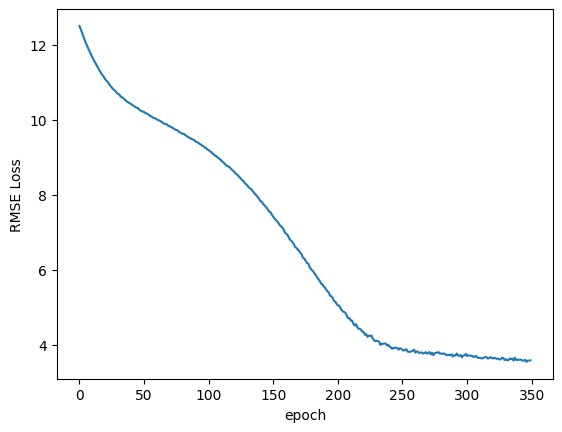

In [72]:
plt.plot(range(epochs), losses)
plt.ylabel('RMSE Loss')
plt.xlabel('epoch');

## Validate the model
Here we want to run the entire test set through the model, and compare it to the known labels.<br>
For this step we don't want to update weights and biases, so we set <tt>torch.no_grad()</tt>

In [73]:
# TO EVALUATE THE ENTIRE TEST SET
with torch.no_grad():
    y_val = model(cat_test, con_test)
    loss = torch.sqrt(criterion(y_val, y_test))
print(f'RMSE: {loss:.8f}')

RMSE: 3.51792979


This means that on average, predicted values are within &plusmn;$3.31 of the actual value.

Now let's look at the first 50 predicted values:

In [74]:
print(f'{"PREDICTED":>12} {"ACTUAL":>8} {"DIFF":>8}')
for i in range(50):
    diff = np.abs(y_val[i].item()-y_test[i].item())
    print(f'{i+1:2}. {y_val[i].item():8.4f} {y_test[i].item():8.4f} {diff:8.4f}')

   PREDICTED   ACTUAL     DIFF
 1.   4.1551   4.9000   0.7449
 2.  12.6283   8.5000   4.1283
 3.   6.6570   4.9000   1.7570
 4.  19.5530  14.9000   4.6530
 5.   8.4256   9.7000   1.2744
 6.  26.9186  30.2700   3.3514
 7.   2.1802   5.3000   3.1198
 8.   7.9414   5.3000   2.6414
 9.   4.4581   6.1000   1.6419
10.   6.6859   6.1000   0.5859
11.   9.8021   9.3000   0.5021
12.   5.5637   5.3000   0.2637
13.   7.0520   4.5000   2.5520
14.  10.5503  33.8700  23.3197
15.   6.1226   5.7000   0.4226
16.   4.4511   5.3000   0.8489
17.  11.2227  10.1000   1.1227
18.   5.3662   6.5000   1.1338
19.   5.9599   5.7000   0.2599
20.  10.2050  12.9000   2.6950
21.   4.8202   4.9000   0.0798
22.   9.5724   7.7000   1.8724
23.   4.3698   4.5000   0.1302
24.   7.7404   6.5000   1.2404
25.  11.5369  10.1000   1.4369
26.   8.1115  10.5000   2.3885
27.   9.6788  12.5000   2.8212
28.   6.3647   4.9000   1.4647
29.   8.2660   5.7000   2.5660
30.   7.0327   8.1000   1.0673
31.  11.9191  12.9000   0.9809
32.   3.

So while many predictions were off by a few cents, some were off by \\$19.00. Feel free to change the batch size, test size, and number of epochs to obtain a better model.

## Save the model
We can save a trained model to a file in case we want to come back later and feed new data through it. The best practice is to save the state of the model (weights & biases) and not the full definition. Also, we want to ensure that only a trained model is saved, to prevent overwriting a previously saved model with an untrained one.<br>For more information visit <a href='https://pytorch.org/tutorials/beginner/saving_loading_models.html'>https://pytorch.org/tutorials/beginner/saving_loading_models.html</a>

In [75]:
# Make sure to save the model only after the training has happened!
if len(losses) == epochs:
    #torch.save(model.state_dict(), 'TaxiFareRegrModel.pt')
    # just avoid rewriting the saved model.
    pass
else:
    print('Model has not been trained. Consider loading a trained model instead.')

## Loading a saved model (starting from scratch)
We can load the trained weights and biases from a saved model. If we've just opened the notebook, we'll have to run standard imports and function definitions. To demonstrate, restart the kernel before proceeding.

In [76]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd

def haversine_distance(df, lat1, long1, lat2, long2):
    r = 6371
    phi1 = np.radians(df[lat1])
    phi2 = np.radians(df[lat2])
    delta_phi = np.radians(df[lat2]-df[lat1])
    delta_lambda = np.radians(df[long2]-df[long1])
    a = np.sin(delta_phi/2)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    return r * c

class TabularModel(nn.Module):
    def __init__(self, emb_szs, n_cont, out_sz, layers, p=0.5):
        super().__init__()
        self.embeds = nn.ModuleList([nn.Embedding(ni, nf) for ni,nf in emb_szs])
        self.emb_drop = nn.Dropout(p)
        # batch normalization continous values
        self.bn_cont = nn.BatchNorm1d(n_cont)
        layerlist = []
        n_emb = sum((nf for ni,nf in emb_szs))
        n_in = n_emb + n_cont
        for i in layers:
            layerlist.append(nn.Linear(n_in,i))
            layerlist.append(nn.ReLU(inplace=True))
            layerlist.append(nn.BatchNorm1d(i))
            layerlist.append(nn.Dropout(p))
            n_in = i
        layerlist.append(nn.Linear(layers[-1],out_sz))
        self.layers = nn.Sequential(*layerlist)
    def forward(self, x_cat, x_cont):
        embeddings = []
        for i,e in enumerate(self.embeds):
            embeddings.append(e(x_cat[:,i]))
        x = torch.cat(embeddings, 1)
        x = self.emb_drop(x)
        x_cont = self.bn_cont(x_cont)
        x = torch.cat([x, x_cont], axis= 1)
        return self.layers(x)

Now define the model. Before we can load the saved settings, we need to instantiate our TabularModel with the parameters we used before (embedding sizes, number of continuous columns, output size, layer sizes, and dropout layer p-value).

In [77]:
emb_szs = [(24, 12), (2, 1), (7, 4)]
model2 = TabularModel(emb_szs, 6, 1, [200,100], p=0.4)


Once the model is set up, loading the saved settings is a snap.

In [78]:
help(model2.eval)
# This is equivalent with :meth:`self.train(False) <torch.nn.Module.train>`.

Help on method eval in module torch.nn.modules.module:

eval() -> ~T method of __main__.TabularModel instance
    Sets the module in evaluation mode.
    
    This has any effect only on certain modules. See documentations of
    particular modules for details of their behaviors in training/evaluation
    mode, if they are affected, e.g. :class:`Dropout`, :class:`BatchNorm`,
    etc.
    
    This is equivalent with :meth:`self.train(False) <torch.nn.Module.train>`.
    
    See :ref:`locally-disable-grad-doc` for a comparison between
    `.eval()` and several similar mechanisms that may be confused with it.
    
    Returns:
        Module: self



In [ ]:
# above says

#This has any effect only on certain modules. See documentations of
#    particular modules for details of their behaviors in training/evaluation
#    mode, if they are affected, e.g. :class:`Dropout`, :class:`BatchNorm`,
#    etc.

In [79]:
model2.load_state_dict(torch.load('TaxiFareRegrModel.pt'));
model2.eval() # be sure to run this step!

Next we'll define a function that takes in new parameters from the user, performs all of the preprocessing steps above, and passes the new data through our trained model.

In [80]:
df['Weekday'].cat.categories

Index(['Fri', 'Mon', 'Sat', 'Sun', 'Thu', 'Tue', 'Wed'], dtype='object')

In [ ]:
# in below Index(['Fri', 'Mon', 'Sat', 'Sun', 'Thu', 'Tue', 'Wed'], dtype='object')
# = [0,1,2,3,4,5,6]

#dfx['Weekday'] = dfx['Weekday'].replace(['Fri','Mon','Sat','Sun','Thu','Tue','Wed'],
#                                            [0,1,2,3,4,5,6]).astype('int64')
    # CREATE CAT AND CONT TENSORS

In [84]:
def test_data(mdl): # pass in the name of the new model
    # INPUT NEW DATA
    print("hrllo")
    plat = float(input('What is the pickup latitude?  '))
    plong = float(input('What is the pickup longitude? '))
    dlat = float(input('What is the dropoff latitude?  '))
    dlong = float(input('What is the dropoff longitude? '))
    psngr = int(input('How many passengers? '))
    dt = input('What is the pickup date and time?\nFormat as YYYY-MM-DD HH:MM:SS     ')

    # PREPROCESS THE DATA
    dfx_dict = {'pickup_latitude':plat,'pickup_longitude':plong,'dropoff_latitude':dlat,
         'dropoff_longitude':dlong,'passenger_count':psngr,'EDTdate':dt}
    dfx = pd.DataFrame(dfx_dict, index=[0])
    dfx['dist_km'] = haversine_distance(dfx,'pickup_latitude', 'pickup_longitude',
                                        'dropoff_latitude', 'dropoff_longitude')
    dfx['EDTdate'] = pd.to_datetime(dfx['EDTdate'])

    # We can skip the .astype(category) step since our fields are small,
    # and encode them right away
    dfx['Hour'] = dfx['EDTdate'].dt.hour
    dfx['AMorPM'] = np.where(dfx['Hour']<12,0,1)
    dfx['Weekday'] = dfx['EDTdate'].dt.strftime("%a")
    dfx['Weekday'] = dfx['Weekday'].replace(['Fri','Mon','Sat','Sun','Thu','Tue','Wed'],
                                            [0,1,2,3,4,5,6]).astype('int64')
    # CREATE CAT AND CONT TENSORS
    cat_cols = ['Hour', 'AMorPM', 'Weekday']
    cont_cols = ['pickup_latitude', 'pickup_longitude', 'dropoff_latitude',
                 'dropoff_longitude', 'passenger_count', 'dist_km']
    xcats = np.stack([dfx[col].values for col in cat_cols], 1)
    xcats = torch.tensor(xcats, dtype=torch.int64)
    xconts = np.stack([dfx[col].values for col in cont_cols], 1)
    xconts = torch.tensor(xconts, dtype=torch.float)
    print(xcats)
    print(xconts)

    # PASS NEW DATA THROUGH THE MODEL WITHOUT PERFORMING A BACKPROP
    with torch.no_grad():
        z = mdl(xcats, xconts)
    print(f'\nThe predicted fare amount is ${z.item():.2f}')

## Feed new data through the trained model
For convenience, here are the max and min values for each of the variables:
<table style="display: inline-block">
<tr><th>Column</th><th>Minimum</th><th>Maximum</th></tr>
<tr><td>pickup_latitude</td><td>40</td><td>41</td></tr>
<tr><td>pickup_longitude</td><td>-74.5</td><td>-73.3</td></tr>
<tr><td>dropoff_latitude</td><td>40</td><td>41</td></tr>
<tr><td>dropoff_longitude</td><td>-74.5</td><td>-73.3</td></tr>
<tr><td>passenger_count</td><td>1</td><td>5</td></tr>
<tr><td>EDTdate</td><td>2010-04-11 00:00:00</td><td>2010-04-24 23:59:42</td></tr>

<strong>Use caution!</strong> The distance between 1 degree of latitude (from 40 to 41) is 111km (69mi) and between 1 degree of longitude (from -73 to -74) is 85km (53mi). The longest cab ride in the dataset spanned a difference of only 0.243 degrees latitude and 0.284 degrees longitude. The mean difference for both latitude and longitude was about 0.02. To get a fair prediction, use values that fall close to one another.

In [ ]:
#pickup_datetime	fare_amount	fare_class	pickup_longitude	pickup_latitude	dropoff_longitude	dropoff_latitude	passenger_count
#2010-04-19 08:17:56 UTC	6.5	0	-73.992365	40.730521	-73.975499	40.744746

In [ ]:
'''
z = test_data(model)
hrllo
What is the pickup latitude?  40.730521
What is the pickup longitude? -73.992365
What is the dropoff latitude?  40.744746
What is the dropoff longitude? -73.975499
How many passengers? 2
What is the pickup date and time?
Format as YYYY-MM-DD HH:MM:SS     2010-04-19 08:17:56
tensor([[8, 0, 1]])
tensor([[ 40.7305, -73.9924,  40.7447, -73.9755,   2.0000,   2.1263]])
---------------------------------------------------------------------------
ValueError                                Traceback (most recent call last)
<ipython-input-74-243ea07c1225> in <cell line: 1>()
----> 1 z = test_data(model)

6 frames
<ipython-input-73-669fdd699ab3> in test_data(mdl)
     37     # PASS NEW DATA THROUGH THE MODEL WITHOUT PERFORMING A BACKPROP
     38     with torch.no_grad():
---> 39         z = mdl(xcats, xconts)
     40     print(f'\nThe predicted fare amount is ${z.item():.2f}')

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py in _call_impl(self, *args, **kwargs)
   1499                 or _global_backward_pre_hooks or _global_backward_hooks
   1500                 or _global_forward_hooks or _global_forward_pre_hooks):
-> 1501             return forward_call(*args, **kwargs)
   1502         # Do not call functions when jit is used
   1503         full_backward_hooks, non_full_backward_hooks = [], []

<ipython-input-53-737cf6dbcea9> in forward(self, x_cat, x_cont)
     32         x = self.emb_drop(x)
     33
---> 34         x_cont = self.bn_cont(x_cont)
     35         x = torch.cat([x, x_cont], 1)
     36         x = self.layers(x)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py in _call_impl(self, *args, **kwargs)
   1499                 or _global_backward_pre_hooks or _global_backward_hooks
   1500                 or _global_forward_hooks or _global_forward_pre_hooks):
-> 1501             return forward_call(*args, **kwargs)
   1502         # Do not call functions when jit is used
   1503         full_backward_hooks, non_full_backward_hooks = [], []

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/batchnorm.py in forward(self, input)
    169         used for normalization (i.e. in eval mode when buffers are not None).
    170         """
--> 171         return F.batch_norm(
    172             input,
    173             # If buffers are not to be tracked, ensure that they won't be updated

/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py in batch_norm(input, running_mean, running_var, weight, bias, training, momentum, eps)
   2446         )
   2447     if training:
-> 2448         _verify_batch_size(input.size())
   2449
   2450     return torch.batch_norm(

/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py in _verify_batch_size(size)
   2414         size_prods *= size[i + 2]
   2415     if size_prods == 1:
-> 2416         raise ValueError("Expected more than 1 value per channel when training, got input size {}".format(size))
   2417
   2418

ValueError: Expected more than 1 value per channel when training, got input size torch.Size([1, 6])'''

'\nz = test_data(model)\nhrllo\nWhat is the pickup latitude?  40.730521\nWhat is the pickup longitude? -73.992365\nWhat is the dropoff latitude?  40.744746\nWhat is the dropoff longitude? -73.975499\nHow many passengers? 2\nWhat is the pickup date and time?\nFormat as YYYY-MM-DD HH:MM:SS     2010-04-19 08:17:56\ntensor([[8, 0, 1]])\ntensor([[ 40.7305, -73.9924,  40.7447, -73.9755,   2.0000,   2.1263]])\n---------------------------------------------------------------------------\nValueError                                Traceback (most recent call last)\n<ipython-input-74-243ea07c1225> in <cell line: 1>()\n----> 1 z = test_data(model)\n\n6 frames\n<ipython-input-73-669fdd699ab3> in test_data(mdl)\n     37     # PASS NEW DATA THROUGH THE MODEL WITHOUT PERFORMING A BACKPROP\n     38     with torch.no_grad():\n---> 39         z = mdl(xcats, xconts)\n     40     print(f\'\nThe predicted fare amount is ${z.item():.2f}\')\n\n/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py 

In [ ]:
# important
# z = test_data(model)
# did not work till model.eval is called
#  as in above at ---> 34         x_cont = self.bn_cont(x_cont)
# as it  assumes it is training and training fails with the error  return F.batch_norm(
#   172             input,
#   173             # If buffers are not to be tracked, ensure that they won't be updated


In [ ]:
# it is failing at BatchNormalization step as if eval is not called it assumes training is going on
# but that layer is receiving only one value  per feature and cannot do any normalization
# as for normalization it needs batch of values per feature.

In [ ]:
model.eval()

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(24, 12)
    (1): Embedding(2, 1)
    (2): Embedding(7, 4)
  )
  (emb_drop): Dropout(p=0.4, inplace=False)
  (bn_cont): BatchNorm1d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=23, out_features=200, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=200, out_features=100, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.4, inplace=False)
    (8): Linear(in_features=100, out_features=1, bias=True)
  )
)

In [ ]:
# help(model.eval)
# This is equivalent with :meth:`self.train(False) <torch.nn.Module.train>`.
z = test_data(model)

hrllo
What is the pickup latitude?  40.730521
What is the pickup longitude? -73.992365
What is the dropoff latitude?  40.744746
What is the dropoff longitude? -73.975499
How many passengers? 2
What is the pickup date and time?
Format as YYYY-MM-DD HH:MM:SS     2010-04-19 08:17:56
tensor([[8, 0, 1]])
tensor([[ 40.7305, -73.9924,  40.7447, -73.9755,   2.0000,   2.1263]])

The predicted fare amount is $7.24


In [ ]:
z = test_data(model2)

hrllo
What is the pickup latitude?  40.730521
What is the pickup longitude? -73.992365
What is the dropoff latitude?  40.744746
What is the dropoff longitude? -73.975499
How many passengers? 2
What is the pickup date and time?
Format as YYYY-MM-DD HH:MM:SS     2010-04-19 08:17:56
tensor([[8, 0, 1]])
tensor([[ 40.7305, -73.9924,  40.7447, -73.9755,   2.0000,   2.1263]])

The predicted fare amount is $7.61


In [ ]:
z = test_data(model2)

hrllo
What is the pickup latitude?  40.730521
What is the pickup longitude? -73.992365
What is the dropoff latitude?  40.744746
What is the dropoff longitude? -73.975499
How many passengers? 1
What is the pickup date and time?
Format as YYYY-MM-DD HH:MM:SS     2010-04-19 08:17:56

The predicted fare amount is $7.37


## Great job!